In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym

from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from collections import deque

GAME = 'LunarLander-v2'
env = gym.make(GAME)

LOG_PATH = 'log/'

In [2]:
ACTIONS = env.action_space.n
ACTIONS

4

In [3]:
STATE_SHAPE = env.observation_space.shape
STATE_SHAPE

(8,)

In [4]:
def build_model():
    return Sequential([
        InputLayer(STATE_SHAPE),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(ACTIONS)
    ])

In [5]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001

EPSILON_DECAY = 0.996       # at each step
MAX_EPSILON = 1
MIN_EPSILON = 0.01
GAMMA = 0.99                # discount
SAVE_FREQUENCY = 50         # frequency(in episodes) in which the model is saved
MIN_EXP_REPLAY = 1000       # min. size of exp. replay

In [6]:
optimizer = Adam(learning_rate=LEARNING_RATE)
model = build_model()
model.compile(optimizer, loss='mean_squared_error')

In [7]:
class Memory(deque):
    def sample(self, n):
        indexes = np.random.choice(len(self), size=n, replace=False)
        minibatch = [self[i] for i in indexes]
        return minibatch
        
    @property
    def size(self):
        return len(self)

In [8]:
experience_replay = Memory(maxlen=500000)

In [9]:
def update_step(experiences):
    cols = len(experiences[0])
    # separate each column of the batch
    states, actions, next_states, rewards, dones = [np.array([experiences[i][k] for i in range(BATCH_SIZE)]) for k in range(cols)]
    
    # mask helps to select desired actions only
    mask = tf.one_hot(actions, depth=ACTIONS)
    
    with tf.GradientTape() as tape:
        q_values = tf.reduce_sum(model(states)*mask, axis=1)
        
        # according to algorithm, gradients are not computed for q_next
        q_values_next = tf.stop_gradient(tf.reduce_max(model(next_states), axis=1))
        
        td_errors = rewards + GAMMA*q_values_next*(1-dones) - q_values
        
        # MSE Error
        loss = tf.reduce_mean(0.5 * (td_errors ** 2)) 
        
    # gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    # backpropagation
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [11]:
# epsilon greedy policy
def get_action(state, epsilon):
    # np.random.uniform() output a random float
    # number between 0 and 1
    if np.random.uniform() < epsilon:    
        # exploring
        action = env.action_space.sample()
    else:
        # exploiting
        q_vals = model(np.expand_dims(state, 0))
        # select action with higher q_values
        action = np.argmax(q_vals)
    return action

In [12]:
def fill_experience_replay():
    state = env.reset()
    
    # fill experience replay buffer with random experiences
    while len(experience_replay) < MIN_EXP_REPLAY:
        # random action
        action = env.action_space.sample()
        # perform random action
        next_state, reward, done, _ = env.step(action)
        # append to experience_replay
        experience_replay.append((state, action ,next_state, reward, done))
        state = next_state
        
        # percentage of fullness
        tmp = len(experience_replay)/MIN_EXP_REPLAY*100
        if tmp % 10 == 0:  print(f"Exp. replay {tmp}%")
            
        if done: state = env.reset()

In [13]:
def save_model(fname):
    model.save_weights(f"model/{fname}.h5")

In [14]:
# create tensorboard writer
writer = tf.summary.create_file_writer(logdir=LOG_PATH)

In [15]:
MAX_EPISODES = 500

n_episodes = 0
epsilon = MAX_EPSILON
episode_reward = 0
total_rewards = []
total_mean_rewards = []
highest_reward = float('-inf')

# filling experience replay
if len(experience_replay) < MIN_EXP_REPLAY: fill_experience_replay()

state = env.reset()

try:
    while n_episodes < MAX_EPISODES:

        # action selection, according to greedy-policy
        action = get_action(state, epsilon)

        # performing the action
        next_state, reward, done, _ = env.step(action)
        env.render()

        # adding experience to experience replay
        experience_replay.append((state, action, next_state, reward, done))

        # learning phase
        minibatch = experience_replay.sample(min(len(experience_replay), BATCH_SIZE))
        update_step(minibatch)
        
        # decrease epsilon
        epsilon = max(MIN_EPSILON, EPSILON_DECAY*epsilon)

        # update actual state
        state = next_state

        episode_reward += reward

        # end of the episode
        if done:
            n_episodes += 1
            total_rewards.append(episode_reward)
            mean_reward = np.mean(total_rewards[-100:])
            total_mean_rewards.append(mean_reward)
            print("Episode %d\t Epsilon %.2f\t Ep.Reward %.2f\t Mean Rew. %.2f" % (n_episodes, epsilon, episode_reward, mean_reward))

            if episode_reward >= highest_reward:
                print("New best score: %.2f. Saving" % episode_reward)
                save_model("best")
                highest_reward = episode_reward

            if n_episodes % SAVE_FREQUENCY == 0:
                save_model(f"auto_{n_episodes}_episodes")
                
            # sending logs to tensorboard
            with writer.as_default():
                tf.summary.scalar('Reward', episode_reward, step=n_episodes)
                tf.summary.scalar('Mean Reward', mean_reward, step=n_episodes)
                writer.flush()

            episode_reward = 0
            
            state = env.reset()
    
except KeyboardInterrupt:
    print("Training interrupted manually...")
    save_model(f"manual_{int(episode_reward)}")

Exp. replay 10.0%
Exp. replay 20.0%
Exp. replay 30.0%
Exp. replay 40.0%
Exp. replay 50.0%
Exp. replay 60.0%
Exp. replay 70.0%
Exp. replay 80.0%
Exp. replay 90.0%
Exp. replay 100.0%
Episode 1	 Epsilon 0.64	 Ep.Reward -103.68	 Mean Rew. -103.68
New best score: -103.68. Saving
Episode 2	 Epsilon 0.30	 Ep.Reward -714.58	 Mean Rew. -409.13
Episode 3	 Epsilon 0.15	 Ep.Reward -451.99	 Mean Rew. -423.42
Episode 4	 Epsilon 0.07	 Ep.Reward 0.97	 Mean Rew. -317.32
New best score: 0.97. Saving
Episode 5	 Epsilon 0.01	 Ep.Reward -185.39	 Mean Rew. -290.93
Episode 6	 Epsilon 0.01	 Ep.Reward -101.89	 Mean Rew. -259.43
Episode 7	 Epsilon 0.01	 Ep.Reward -139.52	 Mean Rew. -242.30
Episode 8	 Epsilon 0.01	 Ep.Reward -153.69	 Mean Rew. -231.22
Episode 9	 Epsilon 0.01	 Ep.Reward -121.95	 Mean Rew. -219.08
Episode 10	 Epsilon 0.01	 Ep.Reward -33.49	 Mean Rew. -200.52
Episode 11	 Epsilon 0.01	 Ep.Reward -88.11	 Mean Rew. -190.30
Episode 12	 Epsilon 0.01	 Ep.Reward -74.87	 Mean Rew. -180.68
Episode 13	 Epsil

In [16]:
with open('rewards.npy', 'wb') as f:
    np.save(f, total_mean_rewards)

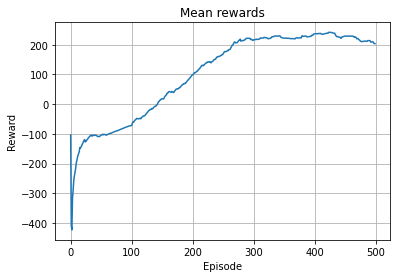

In [14]:
plt.title("Mean rewards")
plt.xlabel('Episode')
plt.ylabel("Reward")
plt.plot(total_mean_rewards)
plt.grid(True)
plt.show()